<h1 ><big><center>Deep Learning 2019/2020</center></big></h1>

<h3><big><center>Liming Chen</center></big></h3>


<h2><big><center> Assignment (3?): GANs </center></big></h2>

<h5><big><center>Adapted from <i>Projet d'Option</i> of : Mhamed Jabri, Martin Chauvin, Ahmed Sahraoui, Zakariae Moustaïne and Taoufik Bouchikhi


<p align="center">
<img height=300px src="https://cdn-images-1.medium.com/max/1080/0*tJRy5Chmk4XymxwN.png"/></p>
<p align="center"></p>

The aim of this assignment is to discover GANs, understand how they are implemented and then explore one specific architecture of GANs that allows us to perform image to image translation (which corresponds to the picture that you can see above this text ! )

So first of all, let's discover what GANs are !

In [42]:
# Importing all the libraries needed
import matplotlib.pyplot as plt
import imageio
import glob
import random
import os
import numpy as np
import math
import itertools
import time
import datetime
import cv2
from pathlib import Path
from PIL import Image


from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

# Part 1 : Introduction to GANs.
*** 

**Generative Adverserial Networks** belong to the set of algorithms named **generative models**. These algorithms belong to the field of unsupervised learning, meaning that they try to learn the **underlying structure** of the given data, without specifying a target value.               
Generative models learn the intrinsic distribution function of the input data p(x) (or p(x,y) if there are multiple targets/classes in the dataset), allowing them to generate both synthetic inputs x’ and outputs/targets y’, typically given some hidden parameters.

Generative Adversarial Networks are composed of two models:

* The first model is called a **Generator** and it aims to generate new data similar to the expected one. You can think of the Generator as a manufacturer that creates fake clothes of luxuary brands.
* The second model is named the **Discriminator**. This model’s goal is to recognize if an input data is ‘real’ — belongs to the original dataset — or if it is ‘fake’ . In this scenario, a Discriminator is analogous to the police (or a fashion expert maybe), which tries to detect clothes as truthful or fraud.

How do these two components interact? **Through competition** ! Well, as we often say, adversity and competition makes better and that's what happens here : the Generator needs to learn how to create data in such a way that the Discriminator isn’t able to distinguish it as fake anymore. The Discriminator needs to learn how to detect fake data that comes from the generator. The competition between these two is what improves their knowledge, until the Generator succeeds in creating realistic data that fools the Discriminator.

Here's a plot showing all of this ! 

![GANs](https://cdn-images-1.medium.com/max/1200/1*5rMmuXmAquGTT-odw-bOpw.jpeg)


## Mathematically, how do they work ?

A neural network G(z, θ₁) is used to model the Generator, Its role is mapping input noise variables *z* to the desired data space *x*. Conversely, a second neural network D(x, θ₂) models the discriminator and outputs the probability that the data came from the real dataset. In both cases, θᵢ represents parameters defining the network.

As a result, the Discriminator is trained to correctly classify the input data as either real or fake. This means **its weights are updated as to maximize the probability that any real data input x is classified as belonging to the real dataset, while minimizing the probability that any fake image is classified as belonging to the real dataset**. In more technical terms, **the loss function used maximizes the function D(x), and it also minimizes D(G(z)).**

Furthermore, the Generator is trained to fool the Discriminator by generating data as realistic as possible, which means that the Generator’s weights are optimized to **maximize the probability that any fake image is classified as belonging to the real dataset**. Formally this means that the **loss function used for this network maximizes D(G(z)).**

Here's the resulting optimization problem : 

$$ \underset{G}{\min} \underset{D}{\max} L(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_z(z)}[\log (1-D(G(z)))] $$

After several steps of training, the Generator and Discriminator reach a point at which both cannot improve anymore : The generator generates realistic synthetic data and the discriminator is unable to differentiate between the two types of input.

## Let's implement a basic GAN then ! 

### Discriminator

The discriminator network is going to be a pretty typical linear classifier. It will be made of 3 hidden layers, will be activated with a leaky ReLu and use dropout layers.

In [27]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_dim*4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3, inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3, inplace=True)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3, inplace=True)
        )
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # final layer
        out = self.fc4(x)

        return out

### Generator

The generator network will be almost exactly the same as the discriminator network, except that hidden layers' dimension become higher as we get closer to the output layer and we're applying a tanh activation function to our output layer.

In [28]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3, inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3, inplace=True)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3, inplace=True)
        )
        
        # final fully-connected layer
        self.fc4 = nn.Sequential(
            nn.Linear(hidden_dim*4, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        # all hidden layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # final layer
        out = self.fc4(x)

        return out

### Build the network

In [29]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

In [30]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout(p=0.3, inplace)
  )
  (fc2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout(p=0.3, inplace)
  )
  (fc3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout(p=0.3, inplace)
  )
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

Generator(
  (fc1): Sequential(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout(p=0.3, inplace)
  )
  (fc2): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout(p=0.3, inplace)
  )
  (fc3): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=Tr

# Part2: cGAN

Let's take the example of the set described in the next picture.
![Map to satellite picture](img/map_streetview.png)
We have a picture of a map (from Google Maps) and we want to create an image of what the satellite view may look like.

As we are not only trying to generate a random picture but a mapping between a picture to another one, we can't use the standard GAN architecture. We will then use a cGAN.

A cGAN is a supervided GAN aiming at mapping a label picture to a real one or a real picture to a label one. As you can see in the diagram below, the discriminator will take as input a pair of images and try to predict if the pair was generated or not. The generator will not only generate an image from noise but will also use an image (label or real) to generate another one (real or label).
![Diagram of how a cGan works](img/cgan_map.png)


### Generator

In the cGAN architecture, the generator chosen is a U-Net
![U-Net](img\unet.png)

A U-Net takes as input an image, and outputs another image. 

It can be divided into 2 subparts : an encoder and a decoder. 
* The encoder takes the input image and reduces its dimension to encode the main features into a vector. 
* The decoder takes this vector and map the features stored into an image.

A U-Net architecture is different from a classic encoder-decoder in that every layer of the decoder takes as input the previous decoded output as well as the output vector from the encoder layers of the same level. It allows the decoder to map low frequencies information encoded during the descent as well as high frequencies from the original picture. 

![U-Net](https://www.researchgate.net/profile/Baris_Turkbey/publication/315514772/figure/fig2/AS:485824962797569@1492841105670/U-net-architecture-Each-box-corresponds-to-a-multi-channel-features-maps-The-number-of.png)

The architecture we will implement is the following (the number in the square is the number of filter used).
![UNet Architecture](img/unet_architecture.png)
The encoder will take as input a colored picture (3 channels: RGB), it will pass through a series of convolution layers to encode the features of the picture. It will then be decoded by the decoder using transposed convolutional layers. These layers will take as input the previous decoded vector AND the encoded features of the same level. 

Let's first create a few classes describing the layers we will use in the U-Net.

In [68]:
# code adapted from https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

# Input layer
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

# Encoder layer
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

# Decoder layer
class up(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=False):
        super(up, self).__init__()
        if dropout :
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
                nn.BatchNorm2d(out_ch),
                nn.Dropout(0.5, inplace=True),
                nn.ReLU(inplace=True)
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

    def forward(self, x1, x2):
        x1 = self.conv(x1)
        x = torch.cat([x1, x2], dim=1)
        return x

# Output layer
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Sequential(
              nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
              nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

Now let's create the U-Net using the helper classes defined previously.

In [69]:
class U_Net(nn.Module):
    ''' 
    Ck denotes a Convolution-BatchNorm-ReLU layer with k filters.
    CDk denotes a Convolution-BatchNorm-Dropout-ReLU layer with a dropout rate of 50%
    Encoder:
      C64   - C128   - C256   - C512  - C512  - C512 - C512 - C512
    Decoder:
      CD512 - CD1024 - CD1024 - C1024 - C1024 - C512 - C256 - C128
    '''
    def __init__(self, n_channels, n_classes):
        super(U_Net, self).__init__()
        # Encoder
        self.inc = inconv(n_channels, 64) # 64 filters
        # To do :
        # Create the 7 encoder layers called down1 to down7 following this sequence
        # C64   - C128   - C256   - C512  - C512  - C512 - C512 - C512
        # The first one has already been implemented
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.down5 = down(512, 512)
        self.down6 = down(512, 512)
        self.down7 = down(512, 512)
        # Decoder
        # To do :
        # Create the 7 decoder layers called up1 to up7 following this sequence :
        # CD512 - CD1024 - CD1024 - C1024 - C1024 - C512 - C256 - C128
        # The last layer has already been defined
        self.up7   = up(512, 512, dropout=True)
        self.up6   = up(1024, 512, dropout=True)
        self.up5   = up(1024, 512, dropout=True)
        self.up4   = up(1024, 512)
        self.up3   = up(1024, 256)
        self.up2   = up(512, 128)
        self.up1   = up(256, 64)
        self.outc = outconv(128, n_classes) # 128 filters

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x7 = self.down6(x6)
        x8 = self.down7(x7)
        # At this stage x8 is our encoded vector, we will now decode it
        x = self.up7(x8, x7)
        x = self.up6(x, x6)
        x = self.up5(x, x5)
        x = self.up4(x, x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)
        x = self.outc(x)
        return x

In [70]:
# We take images that have 3 channels (RGB) as input and output an image that also have 3 channels (RGB)
generator=U_Net(3,3)
# Check that the architecture is as expected
generator

U_Net(
  (inc): inconv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (down1): down(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (down2): down(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (down3): down(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
 

You should now have a working U-Net.

### Discriminator

In the cGAN architecture, the chosen discriminator is a Patch GAN. It is a convolutional discriminator which enables to produce a map of the input pictures where each pixel represents a patch of size NxN of the input.
![patch GAN](img/patchGAN.png)
The size N is given by the depth of the net. According to this table :

| Number of layers | N |
| ---- | ---- |
| 1 | 16 |
| 2 | 34 |
| 3 | 70 |
| 4 | 142 |
| 5 | 286 |
| 6 | 574 |

The number of layers actually means the number of layers with `kernel=(4,4)`, `padding=(1,1)` and `stride=(2,2)`. These layers are followed by 2 layers with `kernel=(4,4)`, `padding=(1,1)` and `stride=(1,1)`.
In our case we are going to create a 70x70 PatchGAN.

Let's first create a few helping classes.

In [95]:
class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch, use_batchnorm=True, stride=2):
        super(conv_block, self).__init__()
        if use_batchnorm:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=4, padding=1, stride=stride),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=4, padding=1, stride=stride),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

    def forward(self, x):
        x = self.conv(x)
        return x
    

class out_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(out_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 1, kernel_size=4, padding=1, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

Now let's create the Patch GAN discriminator.
As we want a 70x70 Patch GAN, the architecture will be as follows :
```
1. C64  - K4, P1, S2
2. C128 - K4, P1, S2
3. C256 - K4, P1, S2
4. C512 - K4, P1, S1
5. C1   - K4, P1, S1 (output)
```
Where Ck denotes a convolution block with k filters, Kk a kernel of size k, Pk is the padding size and Sk the stride applied.
*Note :* For the first layer, we do not use batchnorm.

In [97]:
class PatchGAN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(PatchGAN, self).__init__()
        ## TODO :
        # create the 4 first layers named conv1 to conv4
        self.conv1 = conv_block(n_channels, 64, use_batchnorm=False)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512, stride=1)
        # output layer
        self.out = out_block(512, n_classes)
        
    def forward(self, x1, x2):
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out(x)
        return x

In [98]:
# We have 6 input channels as we concatenate 2 images (with 3 channels each)
discriminator = PatchGAN(6,1)
discriminator

PatchGAN(
  (conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (conv3): conv_block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (conv4): conv_block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slop

You should now have a working discriminator.

### Loss functions

As we have seen in the choice of the various architectures for this GAN, the issue is to map both low and high frequencies.
To tackle this problem, this GAN rely on the architecture to map the high frequencies (U-Net + PatchGAN) and the loss function to learn low frequencies features. The global loss function will indeed be made of 2 parts :
* the first part to map hight frequencies, will try to optimize the mean squared error of the GAN.
* the second part to map low frequencies, will minimize the $\mathcal{L}_1$ norm of the generated picture.

So the loss can be defined as $$ G^* = arg\ \underset{G}{min}\ \underset{D}{max}\ \mathcal{L}_{cGAN}(G,D) + \lambda \mathcal{L}_1(G)$$

In [71]:
# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

### Weights loading and training

We will now load some pre-trained weights and finish the training of the cGAN. For this purpose we made 2 scripts that do it for you 

In [72]:
# parameters
epoch = 0 #  epoch to start training from
n_epoch = 200  #  number of epochs of training
batch_size =10  #  size of the batches
lr = 0.0002 #  adam: learning rate
b1 =0.5  #  adam: decay of first order momentum of gradient
b2 = 0.999  # adam: decay of first order momentum of gradient
decay_epoch = 100  # epoch from which to start lr decay
img_height = 256  # size of image height
img_width = 256  # size of image width
channels = 3  # number of image channels
sample_interval = 500 # interval between sampling of images from generators
checkpoint_interval = -1 # interval between model checkpoints
cuda = True if torch.cuda.is_available() else False # do you have cuda ?

Configure the dataloader

In [73]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train'):
        self.transform = transforms.Compose(transforms_)

        self.files = sorted(glob.glob(os.path.join(root, mode) + '/*.*'))
        if mode == 'val':
            self.files.extend(
                sorted(glob.glob(os.path.join(root, 'val') + '/*.*')))

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], 'RGB')
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], 'RGB')

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return img_A, img_B

    def __len__(self):
        return len(self.files)
    
# Configure dataloaders
transforms_ = [transforms.Resize((img_height, img_width), Image.BICUBIC),
               transforms.ToTensor()]  # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

dataloader = DataLoader(ImageDataset("facades", transforms_=transforms_),
                        batch_size=16, shuffle=True)

val_dataloader = DataLoader(ImageDataset("facades", transforms_=transforms_, mode='val'),
                            batch_size=8, shuffle=False)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Check the loading works and a few helper functions

In [74]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)

    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')


def reverse_transform(image):
    image = image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)

    return image

def plot2x3Array(image, mask,predict):
    f, axarr = plt.subplots(1,3,figsize=(15,15))
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[2].imshow(predict)
    axarr[0].set_title('input')
    axarr[1].set_title('real')
    axarr[2].set_title('fake')

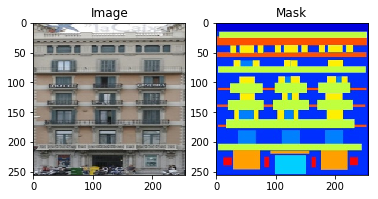

In [75]:
image, mask = next(iter(dataloader))
image = reverse_transform(image[0])
mask = reverse_transform(mask[0])
plot2x2Array(image, mask)

Initialize our GAN

In [99]:
# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height//2**3-2, img_width//2**3-2)

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()
    
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Loading the pretrained weights

In [105]:
load_weights = True

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

if load_weights and 'generator.pth' in os.listdir() and 'discriminator.pth' in os.listdir():
    # load weights 
    checkpoint_generator = torch.load('generator.pth')
    generator.load_state_dict(checkpoint_generator['model_state_dict'])
    optimizer_G.load_state_dict(checkpoint_generator['optimizer_state_dict'])
    epoch_G = checkpoint_generator['epoch']
    loss_G = checkpoint_generator['loss']
    
    checkpoint_discriminator = torch.load('discriminator.pth')
    discriminator.load_state_dict(checkpoint_discriminator['model_state_dict'])
    optimizer_D.load_state_dict(checkpoint_discriminator['optimizer_state_dict'])
    epoch_D = checkpoint_discriminator['epoch']
    loss_D = checkpoint_discriminator['loss']
else :
    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)
    epoch_D = 0
    epoch_G = 0


Start training

In [111]:
def save_model(epoch):
    # save your work
    torch.save({
                'epoch': epoch,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': optimizer_G.state_dict(),
                'loss': loss_G,
                }, 'generator_'+str(epoch)+'.pth')
    torch.save({
                'epoch': epoch,
                'model_state_dict': discriminator.state_dict(),
                'optimizer_state_dict': optimizer_D.state_dict(),
                'loss': loss_D,
                }, 'discriminator_'+str(epoch)+'.pth')

In [108]:
# ----------
#  Training
# ----------
losses = []
num_epochs = 200

# train the network
discriminator.train()
generator.train()
print_every = 400

for epoch in range(epoch_G, num_epochs):
    for i, batch in enumerate(dataloader):

        # Model inputs
        real_A = Variable(batch[0].type(Tensor))
        real_B = Variable(batch[1].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_B.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_B.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_A = generator(real_B)
        pred_fake = discriminator(fake_A, real_B)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_A, real_A)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_A, real_B)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_A.detach(), real_B)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()
        
        # Print some loss stats
        if i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, loss_D.item(), loss_G.item()))
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((loss_D.item(), loss_G.item()))
    if epoch % 100 == 0:
        print('Saving model...')
        save_model(epoch)

Epoch [    1/  200] | d_loss: 0.2800 | g_loss: 49.9325


KeyboardInterrupt: 

Observation de l'évolution de l'entrainement

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Evaluate your cGAN

In [109]:
# switching mode
generator.eval()

U_Net(
  (inc): inconv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (down1): down(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (down2): down(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (down3): down(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
 

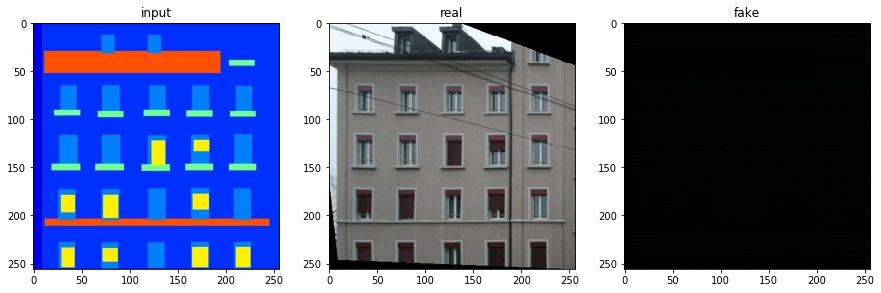

In [110]:
# show a sample evaluation image
image, mask = next(iter(dataloader))
output = generator(mask.type(Tensor))
output = output.view(16, 3, 256, 256)
output = output.cpu().detach()
image = reverse_transform(image[0])
output = reverse_transform(output[0])
mask = reverse_transform(mask[0])
plot2x3Array(mask,image,output)

In [107]:
if cuda:
    torch.cuda.empty_cache()